In [1]:
import torch
import gc

# Clear CUDA cache
torch.cuda.empty_cache()
# Clear memory
gc.collect()

# Restart kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [15]:
# Automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from EDA import *
from data_preprocessing import *
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from unet_model import *
from loss import *
import torch.optim as optim
from torchsummary import summary


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [17]:
# # Define output directory for saving test plots
# OUTPUT_DIR = "visualizations/test_outputs"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

In [18]:
#project_dir = os.path.dirname(os.path.abspath(__file__))
project_dir = os.getcwd() 
data_path = os.path.join(project_dir, "data")
print(data_path)

# EDA - image sizes, top text descriptions, sample data
#run_eda(data_path)

# Split data into train, val and test
#split_data(data_path)



/home/cc/MMI_Unet_Lesion_Segmentation/data


In [19]:
# Preprocess the data - Resize and Augmentation
train_transforms = A.Compose([
    
    A.RandomScale(scale_limit=0.1, p=0.1),  # 10% zoom
    A.Resize(224, 224),
    ToTensorV2() #convert to tensor and normalize
])

val_test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()   
])

train_dataset = SegmentationDataset(data_path, "train", transform=train_transforms)
val_dataset = SegmentationDataset(data_path, "val", transform=val_test_transforms) 
test_dataset = SegmentationDataset(data_path, "test",transform=val_test_transforms) 

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")



Number of training samples: 1089
Number of validation samples: 273
Number of testing samples: 273


In [20]:
BATCH_SIZE = 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [21]:
for images, masks, text_descriptions in train_loader:
    print(f"Image type: {type(images)}")
    print(f"Image shape: {images.shape}")
    print(f"Image data type: {images.dtype}") 
    
    print(f"Text description type: {type(text_descriptions)}")

    print(f"Mask type: {type(masks)}")
    print(f"Mask shape: {masks.shape}")
    print(f"Mask data type: {masks.dtype}")


    break

Image type: <class 'torch.Tensor'>
Image shape: torch.Size([1, 3, 224, 224])
Image data type: torch.float32
Text description type: <class 'tuple'>
Mask type: <class 'torch.Tensor'>
Mask shape: torch.Size([1, 1, 224, 224])
Mask data type: torch.float32


In [22]:
from torchinfo import summary
from seg_text_unet_model import MMI_UNet
import torch

#model = MMI_UNet(out_channels=1)

#summary(model)

In [23]:
# images = torch.randn(1, 3, 224, 224)  
# reports = [
# "Bilateral pulmonary infection, two infected areas, all left lung and middle right lung."
# ]

# # The model handles the text encoding internally
# segmentation_maps = model(images, reports)

In [24]:
# print(segmentation_maps)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
from loss import *
from train import *
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = MMI_UNet(out_channels=1).to(device)

# Loss and optimizer
criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)


In [27]:
import sys
import os
import contextlib
import matplotlib.pyplot as plt 
import torch 

# --- Configuration ---
LOG_FILE_PATH = "training_log.txt"
TEST_OUTPUT_DIR = "visualizations/test_outputs"

os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)
print(f"Test image outputs will be saved to: {TEST_OUTPUT_DIR}")
print(f"Training and testing logs will be saved to: {LOG_FILE_PATH}") 


# --- Context Manager for Logging ---
@contextlib.contextmanager
def log_stdout_to_file(filename, mode='w'): 
    original_stdout = sys.stdout
    try:
        with open(filename, mode) as log_file: # Use the mode argument
            sys.stdout = log_file
            yield # Executes the code within the 'with' block
    finally:
        sys.stdout = original_stdout # Restores normal printing


Test image outputs will be saved to: visualizations/test_outputs
Training and testing logs will be saved to: training_log.txt


In [28]:


# Train the model and save output to log file
print("Starting Training...") # Prints to notebook
with log_stdout_to_file(LOG_FILE_PATH): # Use 'w' to overwrite/start log
    print("--- Training Log Start ---") # Goes to file
    train(model, train_loader, val_loader, criterion, optimizer, epochs=60)
    print("--- Training Log End ---") # Goes to file
print("Training Finished.") # Prints to notebook



Starting Training...
Training Finished.


Starting Testing...


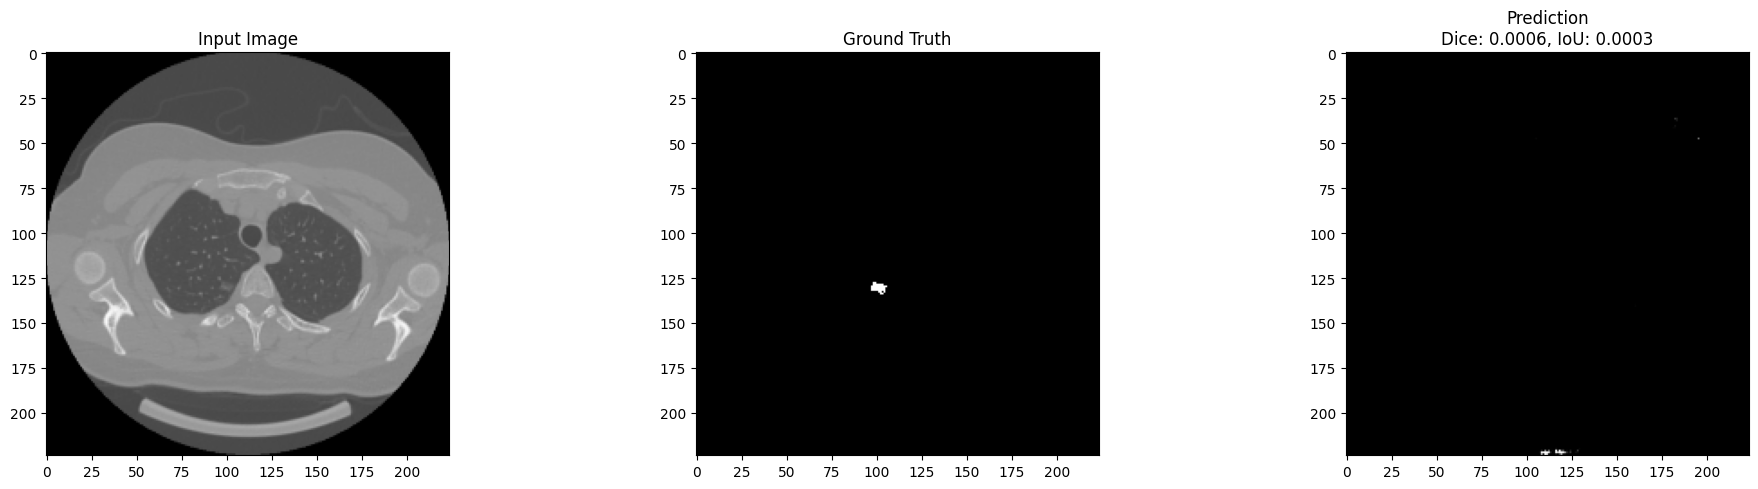

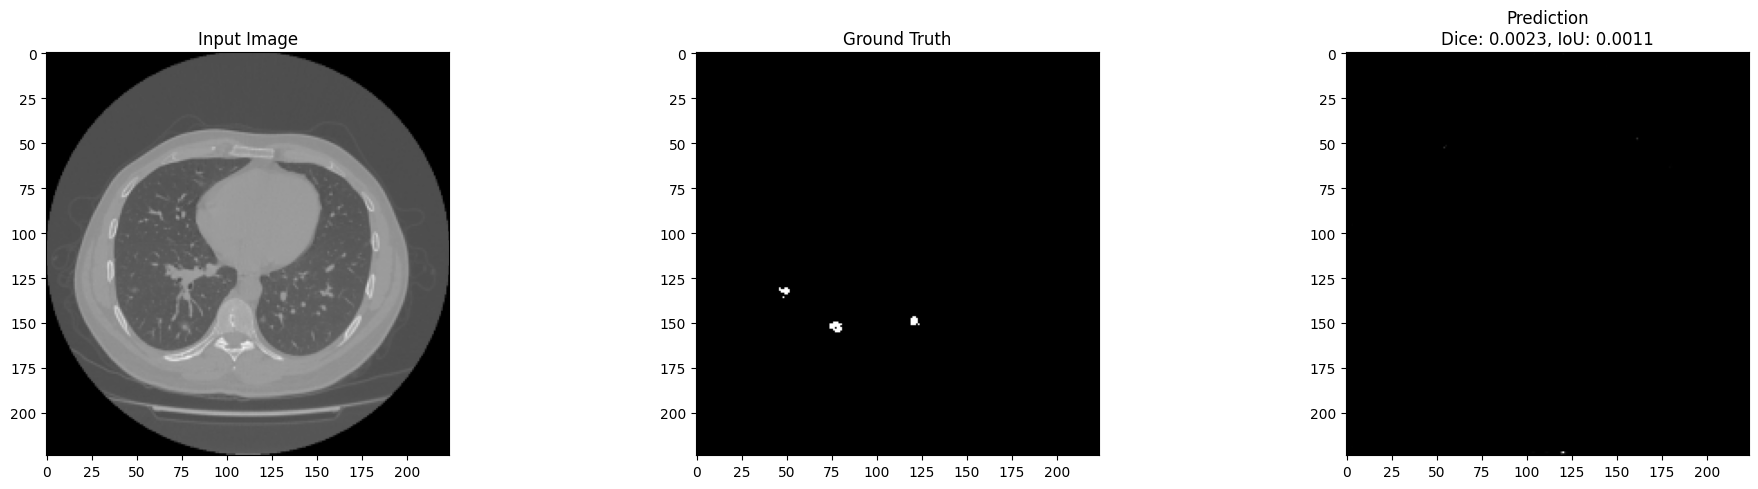

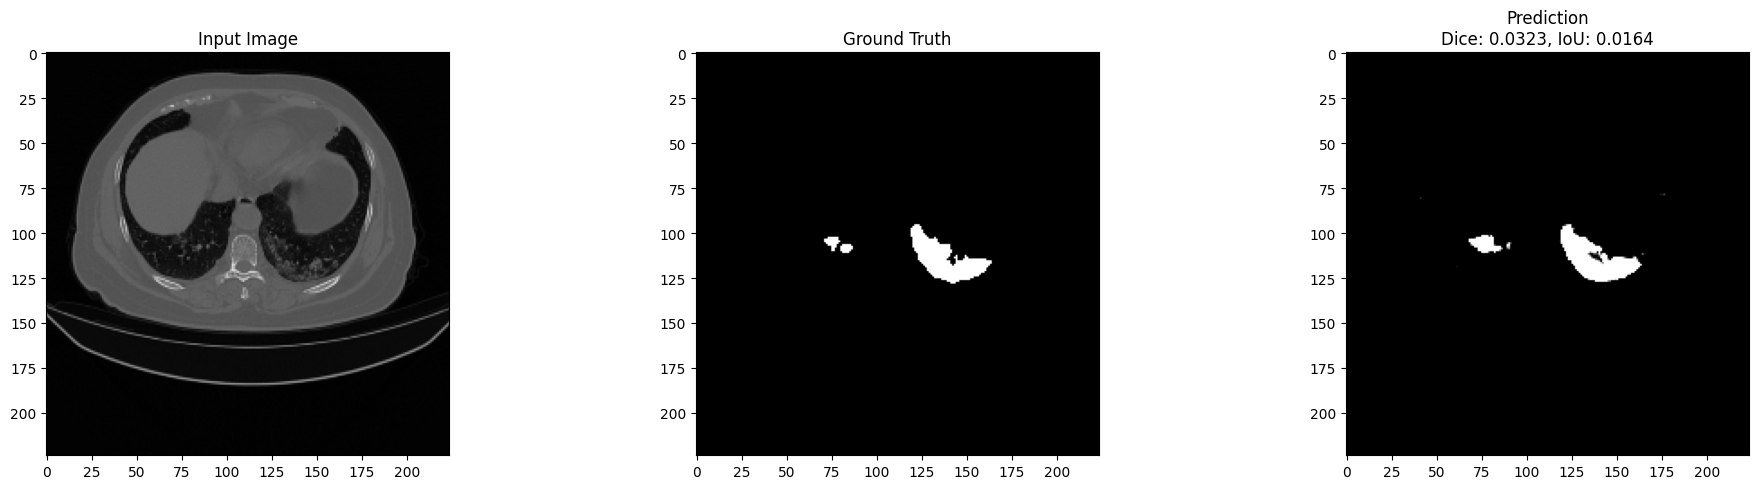

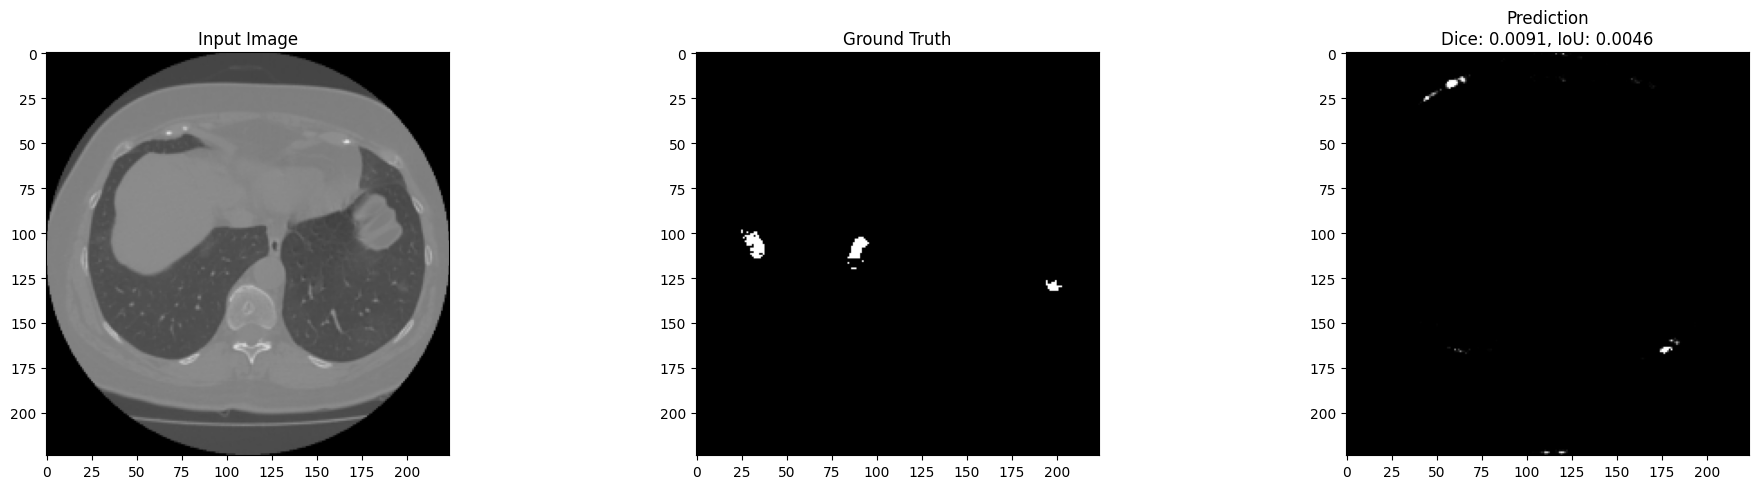

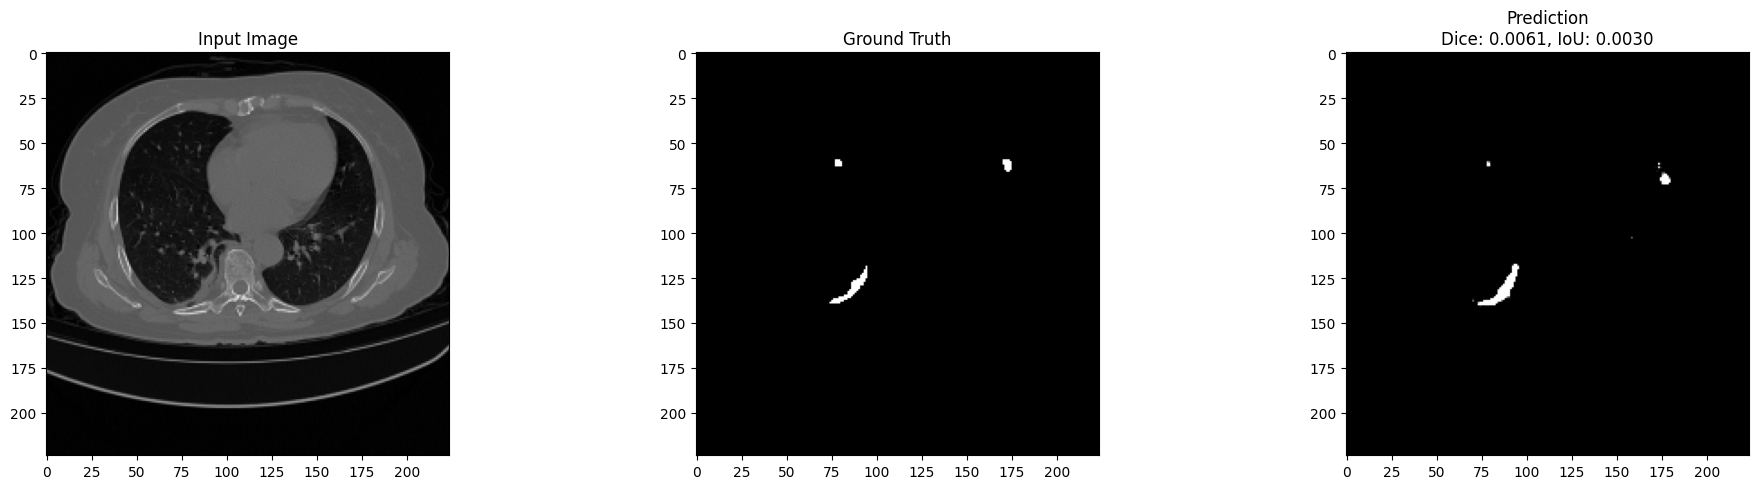

Testing Finished.


In [29]:
print("Starting Testing...") # Prints to notebook
with log_stdout_to_file(LOG_FILE_PATH, 'a'): # Use 'a' to append to the log file
    print("--- Testing Log Start ---") # Goes to file

    model.eval()
    total_dice, total_iou, num_samples = 0, 0, 0

    with torch.no_grad():
        for i, (image, mask, text) in enumerate(test_loader):
            # Model computations on GPU
            image, mask = image.to(device), mask.to(device)
            pred = model(image, text)
            pred = torch.sigmoid(pred)

            # Metrics computation on GPU
            dice = dice_score(pred, mask).item()
            iou = iou_score(pred, mask).item()
            total_dice += dice
            total_iou += iou
            num_samples += 1

            # Visualization - need to move to CPU for matplotlib
            if i < 5:  
                plt.figure(figsize=(20, 5))
                
                # Move to CPU only for visualization
                img_display = image.cpu()[0].permute(1, 2, 0).numpy()
                mask_display = mask.cpu()[0].squeeze().numpy()
                pred_display = pred.cpu()[0].squeeze().numpy()
                
                plt.subplot(1, 3, 1)
                plt.imshow(img_display)
                plt.title("Input Image")
                
                plt.subplot(1, 3, 2)
                plt.imshow(mask_display, cmap="gray")
                plt.title("Ground Truth")
                
                plt.subplot(1, 3, 3)
                plt.imshow(pred_display, cmap="gray")
                plt.title(f"Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}")
                
                plt.tight_layout()
                plt.show()
                plot_path = os.path.join(TEST_OUTPUT_DIR, f"test_case_{i}.png")
                plt.savefig(plot_path, bbox_inches="tight")
                plt.close()
        
                print(f"Saved test visualization: {plot_path}")

    print(f"Test Dice Score: {total_dice / num_samples:.4f}")
    print(f"Test IoU Score: {total_iou / num_samples:.4f}")
    print("--- Testing Log End ---") # Goes to file
print("Testing Finished.") # Prints to notebook

In [30]:
# # --- Define path to saved weights ---
# WEIGHTS_PATH = "mmi_unet_model.pth" # Assuming it's in the same directory as the notebook

# # --- Load the model ---
# print(f"Loading model weights from: {WEIGHTS_PATH}")
# # Instantiate the model architecture
# model = MMI_UNet(out_channels=1).to(device) # Make sure MMI_UNet is defined/imported

# # Load the saved state dictionary
# try:
#     model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
#     print("Model weights loaded successfully.")
# except FileNotFoundError:
#     print(f"Error: Weights file not found at {WEIGHTS_PATH}. Please ensure the model is trained and saved.")
#     # Optionally, exit or raise an error here if testing cannot proceed
#     raise SystemExit(f"Weights file not found: {WEIGHTS_PATH}")
# except Exception as e:
#     print(f"Error loading model weights: {e}")
#     raise SystemExit(f"Error loading weights: {e}")

In [31]:
# print("Starting Testing...") # Prints to notebook
# with log_stdout_to_file(LOG_FILE_PATH, 'a'): # Use 'a' to append to the log file
#     print("--- Testing Log Start ---") # Goes to file

#     model.eval()
#     total_dice, total_iou, num_samples = 0, 0, 0

#     with torch.no_grad():
#         for i, (image, mask, text) in enumerate(test_loader):
#             # Model computations on GPU
#             image, mask = image.to(device), mask.to(device)
#             pred = model(image, text)
#             pred = torch.sigmoid(pred)

#             # Metrics computation on GPU
#             dice = dice_score(pred, mask).item()
#             iou = iou_score(pred, mask).item()
#             total_dice += dice
#             total_iou += iou
#             num_samples += 1

#             # Visualization - need to move to CPU for matplotlib
#             if i < 5:  
#                 plt.figure(figsize=(20, 5))
                
#                 # Move to CPU only for visualization
#                 img_display = image.cpu()[0].permute(1, 2, 0).numpy()
#                 mask_display = mask.cpu()[0].squeeze().numpy()
#                 pred_display = pred.cpu()[0].squeeze().numpy()
                
#                 plt.subplot(1, 3, 1)
#                 plt.imshow(img_display)
#                 plt.title("Input Image")
                
#                 plt.subplot(1, 3, 2)
#                 plt.imshow(mask_display, cmap="gray")
#                 plt.title("Ground Truth")
                
#                 plt.subplot(1, 3, 3)
#                 plt.imshow(pred_display, cmap="gray")
#                 plt.title(f"Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}")
                
#                 plt.tight_layout()
#                 plt.show()
#                 plot_path = os.path.join(TEST_OUTPUT_DIR, f"test_case_{i}.png")
#                 plt.savefig(plot_path, bbox_inches="tight")
#                 plt.close()
        
#                 print(f"Saved test visualization: {plot_path}")

#     print(f"Test Dice Score: {total_dice / num_samples:.4f}")
#     print(f"Test IoU Score: {total_iou / num_samples:.4f}")
#     print("--- Testing Log End ---") # Goes to file
# print("Testing Finished.") # Prints to notebook

Starting Testing with threshold output...


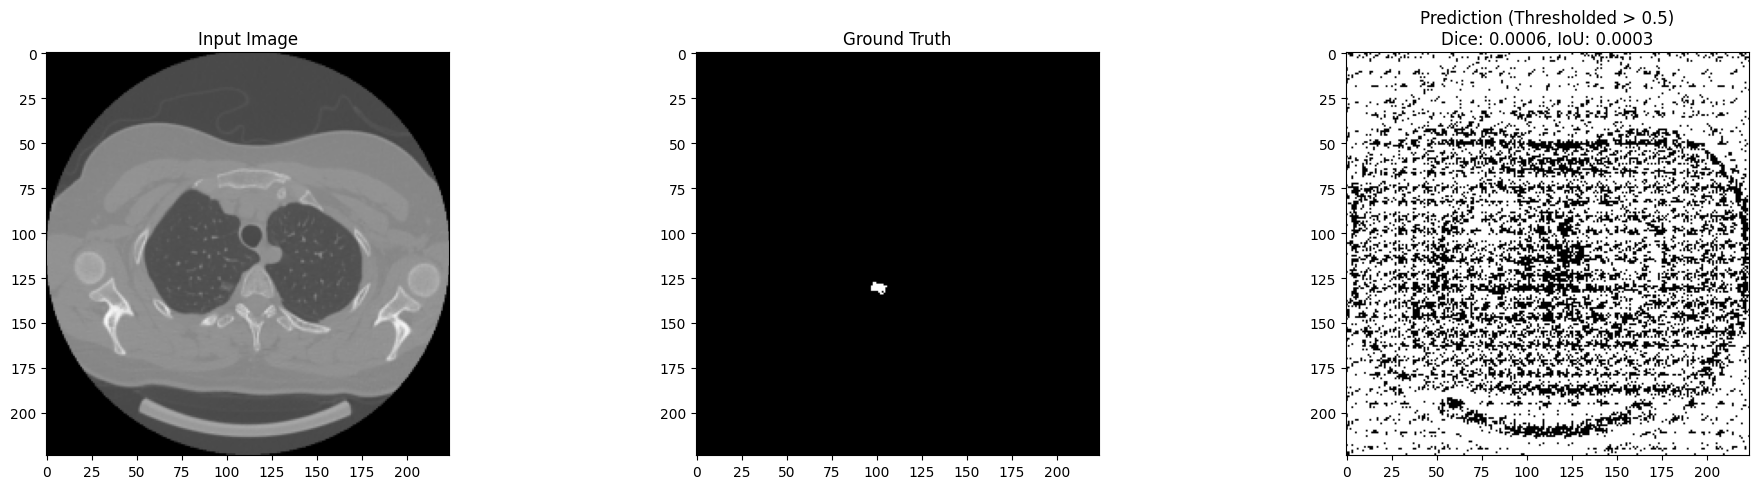

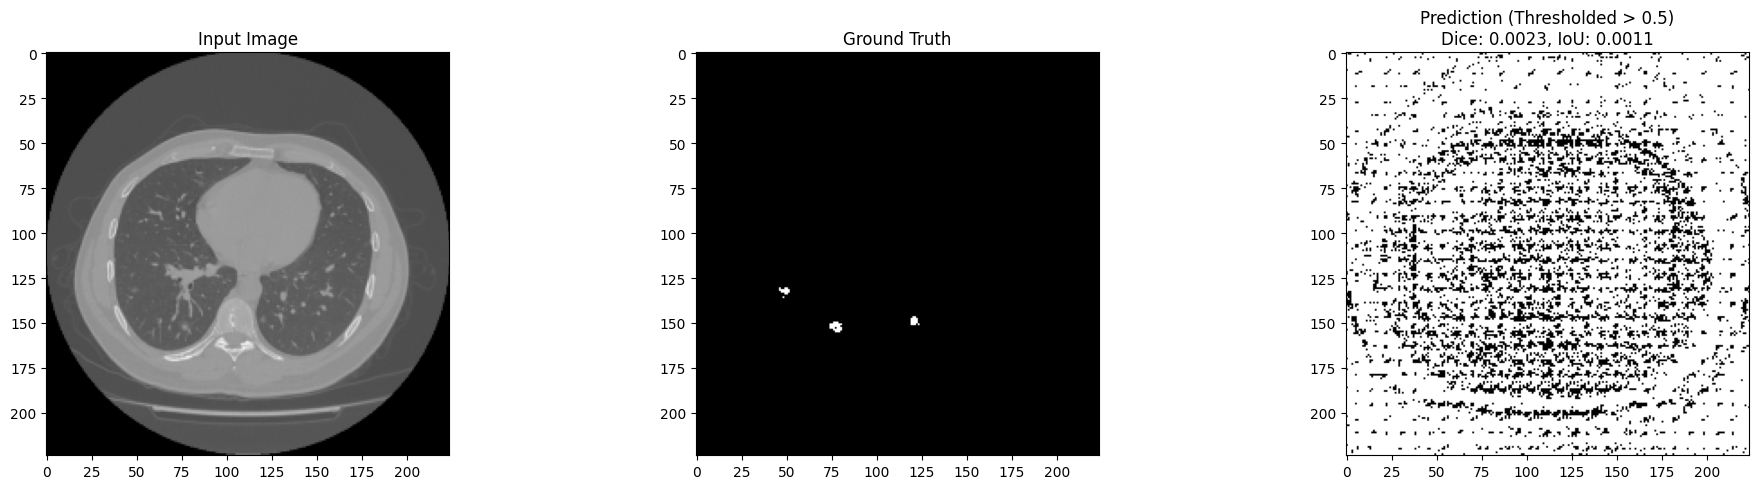

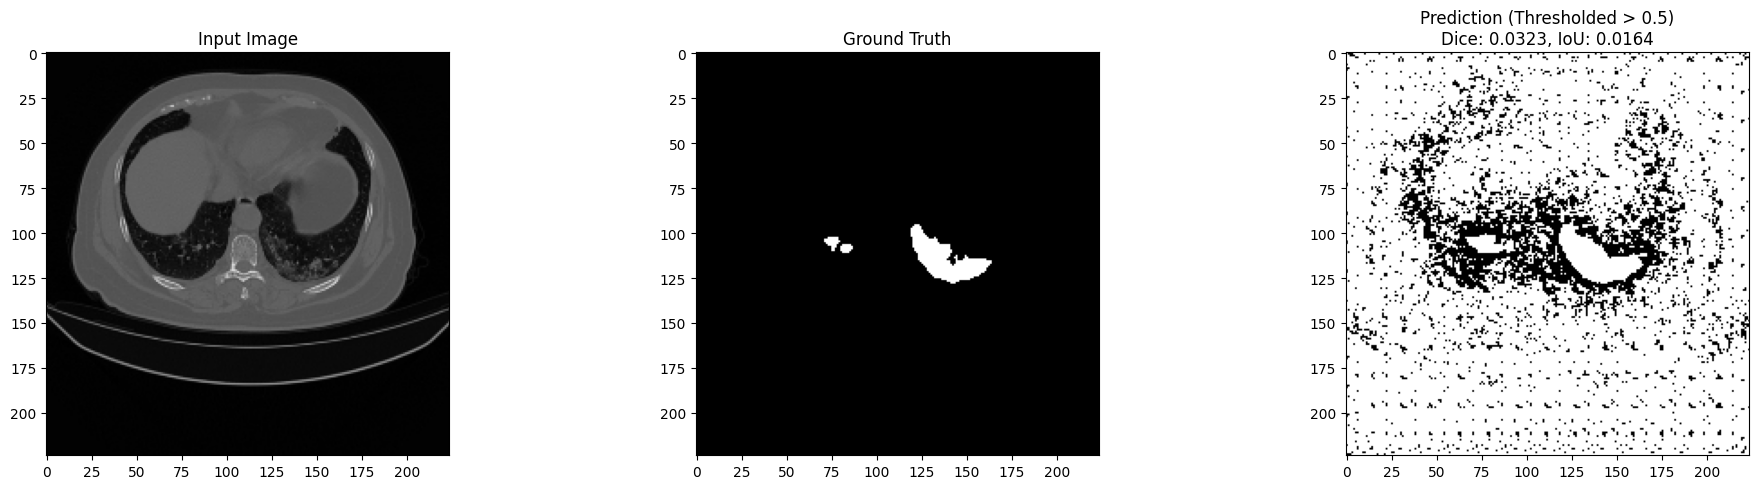

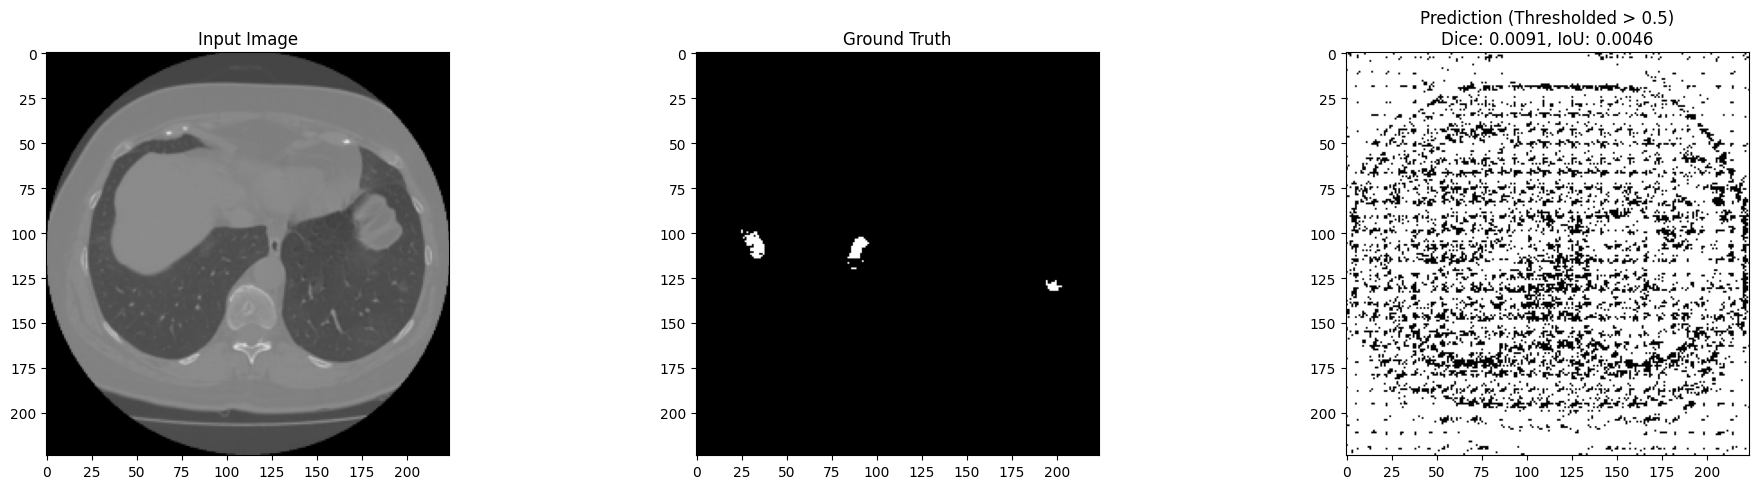

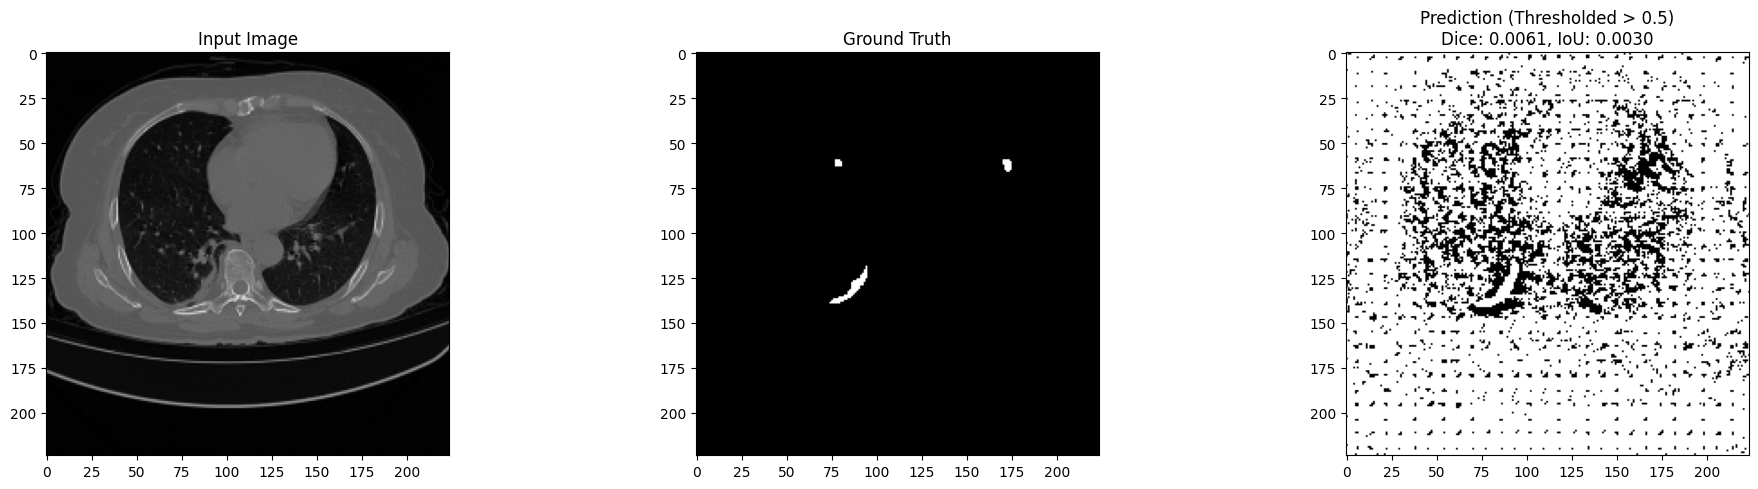

Testing Finished.


In [32]:
print("Starting Testing with threshold output...") # Prints to notebook
with log_stdout_to_file(LOG_FILE_PATH, 'a'): # Use 'a' to append to the log file
    print("--- Testing Log Start ---") # Goes to file

    model.eval()
    total_dice, total_iou, num_samples = 0, 0, 0

    with torch.no_grad():
        for i, (image, mask, text) in enumerate(test_loader):
            # Model computations on GPU
            image, mask = image.to(device), mask.to(device)
            pred = model(image, text)
            pred = torch.sigmoid(pred)

            # Metrics computation on GPU
            dice = dice_score(pred, mask).item()
            iou = iou_score(pred, mask).item()
            total_dice += dice
            total_iou += iou
            num_samples += 1

            # Visualization - need to move to CPU for matplotlib
            if i < 5:
                plt.figure(figsize=(20, 5))

                # Move to CPU only for visualization
                img_display = image.cpu()[0].permute(1, 2, 0).numpy()
                mask_display = mask.cpu()[0].squeeze().numpy()
                pred_probabilities_display = pred.cpu()[0].squeeze().numpy() # Get probabilities

                # --- Apply threshold for visualization ---
                threshold = 0.5
                pred_binary_display = (pred_probabilities_display > threshold).astype(float) # Convert boolean to float for imshow
                # -----------------------------------------

                plt.subplot(1, 3, 1)
                plt.imshow(img_display)
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_display, cmap="gray")
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                # --- Use the binary mask for plotting ---
                plt.imshow(pred_binary_display, cmap="gray")
                # ----------------------------------------
                plt.title(f"Prediction (Thresholded > {threshold})\nDice: {dice:.4f}, IoU: {iou:.4f}")

                plt.tight_layout()
                plt.show() 
                plot_path = os.path.join(TEST_OUTPUT_DIR, f"thresholded_test_case_{i}.png")
                plt.savefig(plot_path, bbox_inches="tight")
                plt.close()

                print(f"Saved test visualization: {plot_path}") # This will go to the log file

    # --- Recalculate average metrics AFTER the loop ---
    avg_dice = total_dice / num_samples
    avg_iou = total_iou / num_samples
    # ----------------------------------------------------

    # --- Print final averages to the log file ---
    print(f"Average Test Dice Score: {avg_dice:.4f}")
    print(f"Average Test IoU Score: {avg_iou:.4f}")
    # ------------------------------------------
    print("--- Testing Log End ---") # Goes to file
print("Testing Finished.") # Prints to notebook
